In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\ezlik\AppData\Roaming\Python\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 1. SVM with Linear, Polynomial and RBF kernel

In [26]:
class SVM_model():
    
    def __init__(self, kernel, symbol, start, end=datetime.datetime.today()):
        
        self.kernel = kernel
        self.symbol = symbol
        self.start = start
        self.end = end
        self.get_data()
        
    def get_data(self):
        
        # download data
        data = yf.download(self.symbol, self.start, self.end)
        
        # target
        target = "Close"
        
        # features
        predictor = ["Open", "High", "Low", "Volume"]
        
        # create features
        X = data[predictor]
        y = data[target]
        
        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # create model
        self.svm = SVR(
            kernel=self.kernel, 
            degree=3, 
            gamma='scale', 
            coef0=0.0, 
            tol=0.001, 
            C=1.0, 
            epsilon=0.1, 
            shrinking=True, 
            cache_size=200, 
            verbose=False, 
            max_iter=5)
        
        # fit model
        self.svm.fit(X_train, y_train)
        
        # evaluate model
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, self.svm.predict(X_test))))
        print("R2: ", r2_score(y_test, self.svm.predict(X_test)))
        
        # generate predictions
        data["predicted"] = self.svm.predict(X)
        buysignals = data[data["Close"] < data["predicted"]]
        sellsignals = data[data["Close"] > data["predicted"]]
        
        # position
        data["Position"] = np.where(data["Close"] < data["predicted"], 1, -1)
        
        # buy_and_hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
        
        # strategy returns
        data["strategy"] = data["Position"].shift(1) * data["buy_and_hold"]
        
        # drop na
        data.dropna(inplace=True)
        
        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals 
    
    def performance_summary(self):
        
        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} SVM with {self.kernel} kernel Model Performance")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()        

[*********************100%***********************]  1 of 1 completed
RMSE:  40.28270067457148
R2:  -5.589038467590032
Sum of buy_and_hold:
buy_and_hold    0.918107
strategy        0.400344
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-01-03      0.990278  0.990278
2020-01-06      0.998169  0.998169
2020-01-07      0.993474  0.993474
2020-01-08      1.009456  1.009456
2020-01-09      1.030897  1.030897
...                  ...       ...
2023-06-21      2.449942  1.525598
2023-06-22      2.490428  1.500797
2023-06-23      2.486166  1.503370
2023-06-26      2.467388  1.514811
2023-06-27      2.504545  1.492338

[876 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-03
End date,2023-06-27
Total months,41
,Backtest
Annual return,5.4%
Cumulative returns,20.2%
Annual volatility,35.2%
Sharpe ratio,0.33
Calmar ratio,0.13
Stability,0.11
Max drawdown,-42.0%


##################################################


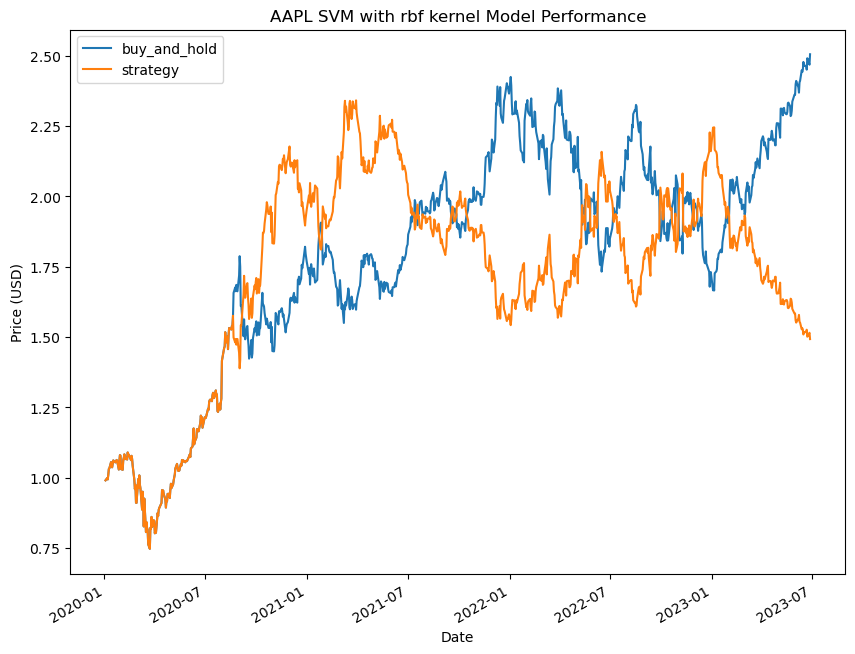

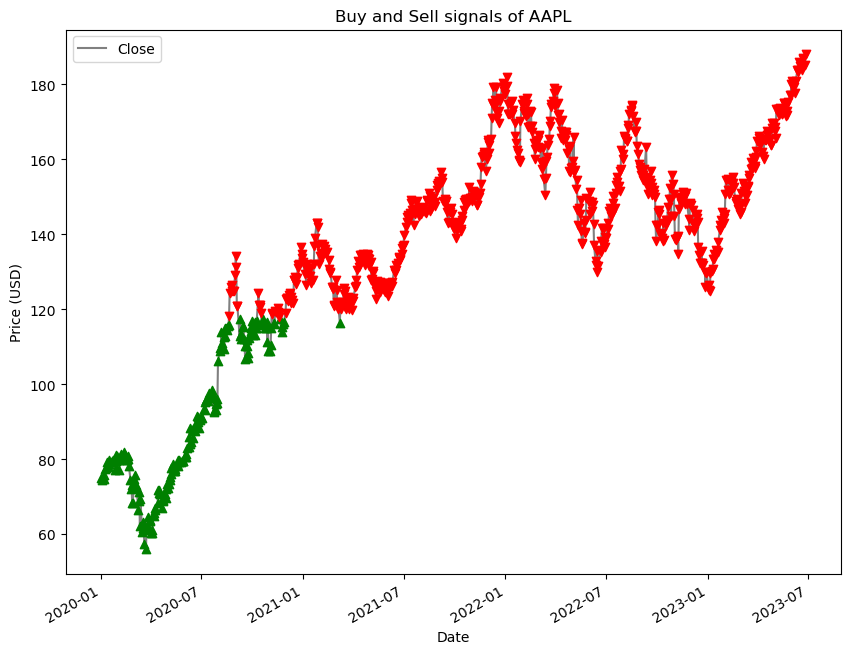

In [27]:
aapl = SVM_model(kernel="rbf", symbol="AAPL", start="2020-01-01")
aapl.performance_summary()

[*********************100%***********************]  1 of 1 completed
RMSE:  40.29220565022501
R2:  -5.592148290814021
Sum of buy_and_hold:
buy_and_hold    0.918107
strategy        0.400344
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-01-03      0.990278  0.990278
2020-01-06      0.998169  0.998169
2020-01-07      0.993474  0.993474
2020-01-08      1.009456  1.009456
2020-01-09      1.030897  1.030897
...                  ...       ...
2023-06-21      2.449942  1.525598
2023-06-22      2.490428  1.500797
2023-06-23      2.486166  1.503370
2023-06-26      2.467388  1.514811
2023-06-27      2.504545  1.492338

[876 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-03
End date,2023-06-27
Total months,41
,Backtest
Annual return,5.4%
Cumulative returns,20.2%
Annual volatility,35.2%
Sharpe ratio,0.33
Calmar ratio,0.13
Stability,0.11
Max drawdown,-42.0%


##################################################


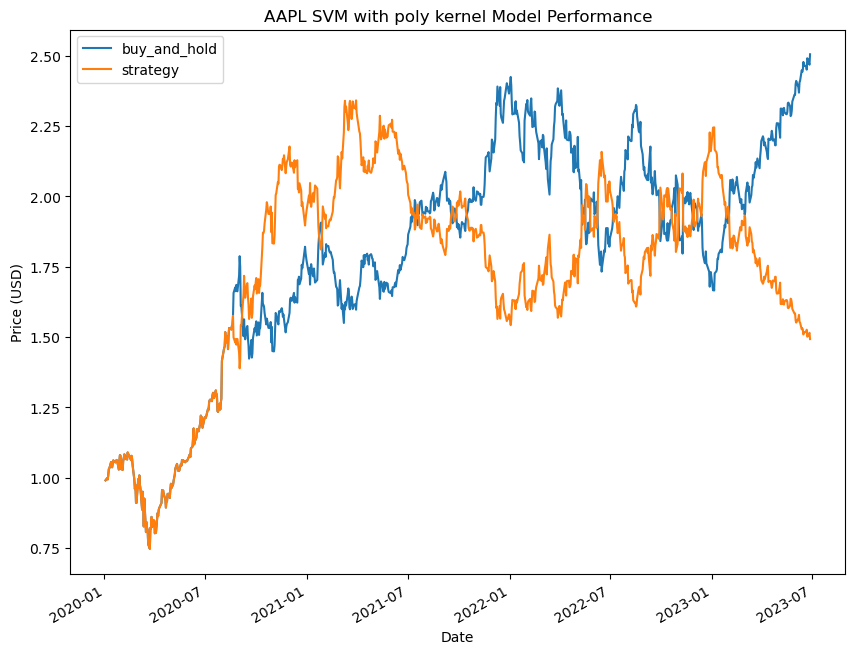

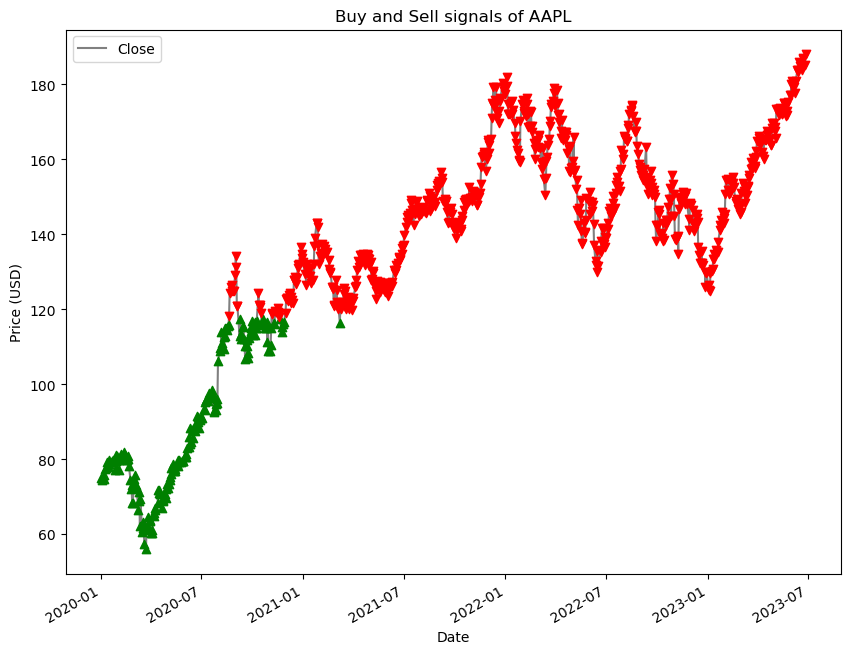

In [28]:
aapl = SVM_model(kernel="poly", symbol="AAPL", start="2020-01-01")
aapl.performance_summary()

[*********************100%***********************]  1 of 1 completed
RMSE:  21677.978570174524
R2:  -2420605.6605342324
Sum of buy_and_hold:
buy_and_hold    1.928685
strategy        2.088996
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2015-01-05      0.971828  1.028988
2015-01-06      0.971920  1.028891
2015-01-07      0.985548  1.014664
2015-01-08      1.023415  1.053649
2015-01-09      1.024513  1.052520
...                  ...       ...
2023-06-21      6.730449  7.900715
2023-06-22      6.841672  8.031277
2023-06-23      6.829964  8.017533
2023-06-26      6.778377  7.956977
2023-06-27      6.880453  8.076801

[2134 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2015-01-05
End date,2023-06-27
Total months,101
,Backtest
Annual return,22.5%
Cumulative returns,458.0%
Annual volatility,29.6%
Sharpe ratio,0.83
Calmar ratio,0.53
Stability,0.90
Max drawdown,-42.5%


##################################################


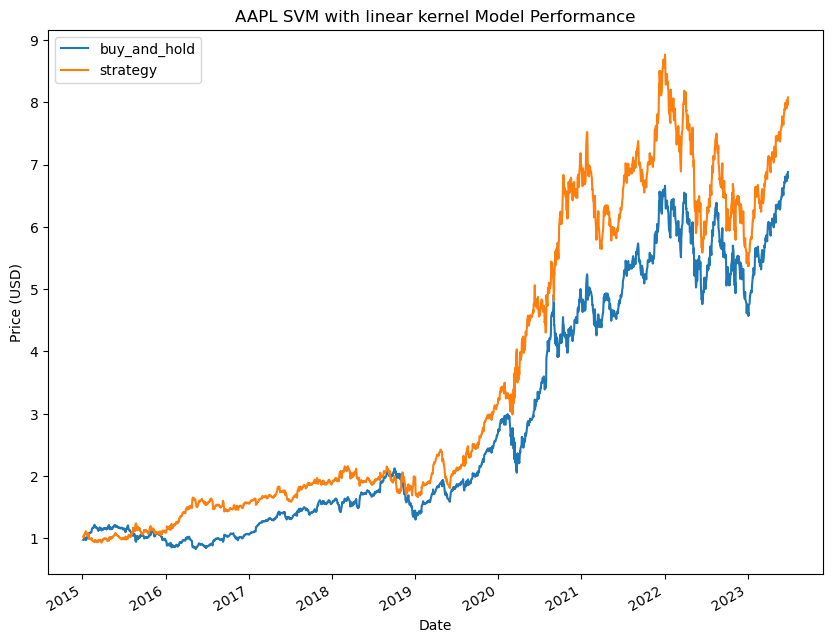

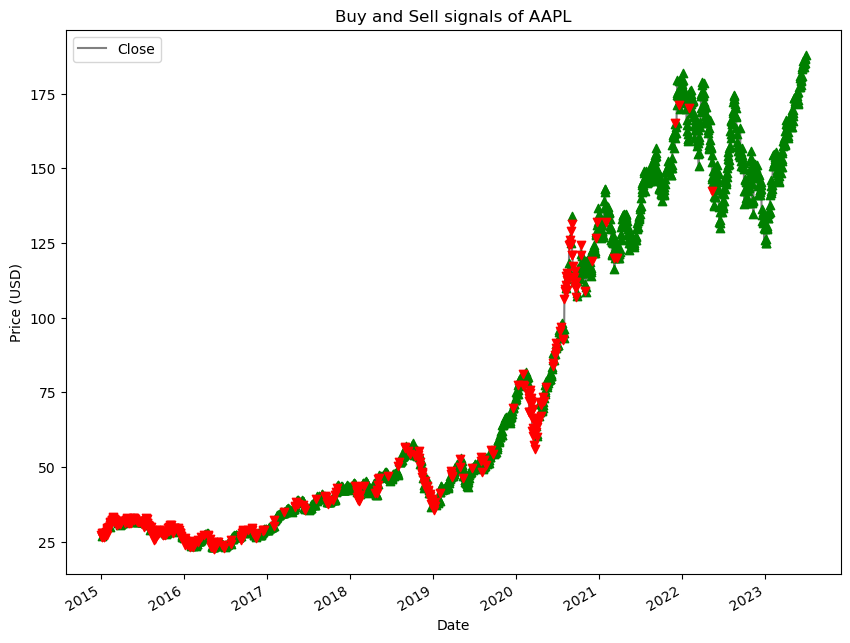

In [32]:
aapl = SVM_model(kernel="linear", symbol="AAPL", start="2015-01-01")
aapl.performance_summary()